# Day 7 Part 2

# "THE PRICE IS RIGHT" Capstone Project

This week - fine tune an open-source model!

A model that can estimate how much something costs, from its description.

## First we need to upload the final dataset



In [2]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from pricer.items import Item
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt


In [17]:
LITE_MODE = True  #False for large Dataset

load_dotenv(override=True)
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
username = "ed-donner"
dataset = f"{username}/items_lite" if LITE_MODE else f"{username}/items_full"

train, val, test = Item.from_hub(dataset)
items = train + val + test

print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

README.md:   0%|          | 0.00/735 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/304k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/304k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loaded 20,000 training items, 1,000 validation items, 1,000 test items


In [7]:
BASE_MODEL = "meta-llama/Llama-3.2-3B"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [8]:
token_counts = [item.count_tokens(tokenizer) for item in tqdm(items)]

  0%|          | 0/22000 [00:00<?, ?it/s]

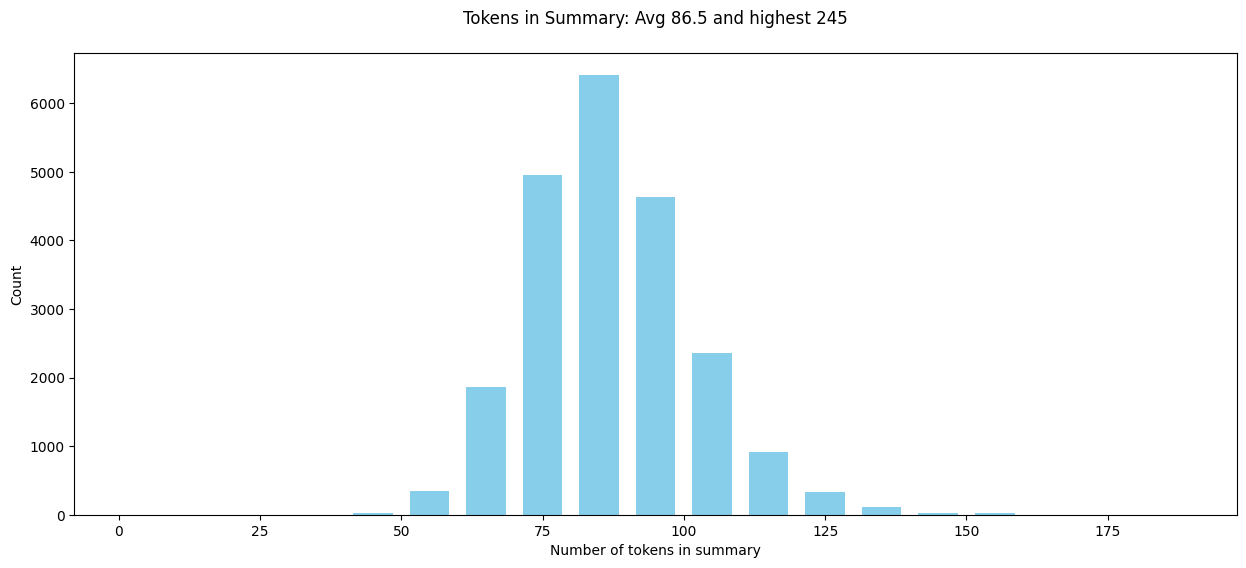

In [9]:
plt.figure(figsize=(15, 6))
plt.title(f"Tokens in Summary: Avg {sum(token_counts)/len(token_counts):,.1f} and highest {max(token_counts):,}\n")
plt.xlabel('Number of tokens in summary')
plt.ylabel('Count')
plt.hist(token_counts, rwidth=0.7, color="skyblue", bins=range(0, 200, 10))
plt.show()

In [10]:
CUTOFF = 110
cut = len([count for count in token_counts if count > CUTOFF])
print(f"With this CUTOFF, we will truncate {cut:,} items which is {cut/len(items):.1%}")


With this CUTOFF, we will truncate 1,255 items which is 5.7%


In [11]:
print(train[0].summary)

Title: Schlage F59 & 613 Andover Interior Knob (Deadbolt Included)  
Category: Home Hardware  
Brand: Schlage  
Description: A single‑piece oil‑rubbed bronze knob that mounts to a deadbolt for secure, easy interior door use.  
Details: Designed for a 4" minimum center‑to‑center door prep, it offers a lifetime mechanical and finish warranty and comes ready for quick installation.


In [12]:
for item in tqdm(train+val):
    item.make_prompts(tokenizer, CUTOFF, True)
for item in tqdm(test):
    item.make_prompts(tokenizer, CUTOFF, False)

  0%|          | 0/21000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
print("PROMPT:")
print(test[0].prompt)
print("COMPLETION:")
print(test[0].completion)


PROMPT:
What does this cost to the nearest dollar?

Title: Excess V2 Distortion/Modulation Pedal  
Category: Music Pedals  
Brand: Old Blood Noise  
Description: A versatile pedal offering distortion and three modulation modes—delay, chorus, and harmonized fifths—with full control over signal routing and expression.  
Details: Features include separate gain, tone, and volume controls; time, depth, and volume per modulation; order switching, soft‑touch bypass, and expression jack for dynamic control.

Price is $
COMPLETION:
219.0


In [14]:
prompt_token_counts = [item.count_prompt_tokens(tokenizer) for item in tqdm(items)]

  0%|          | 0/22000 [00:00<?, ?it/s]

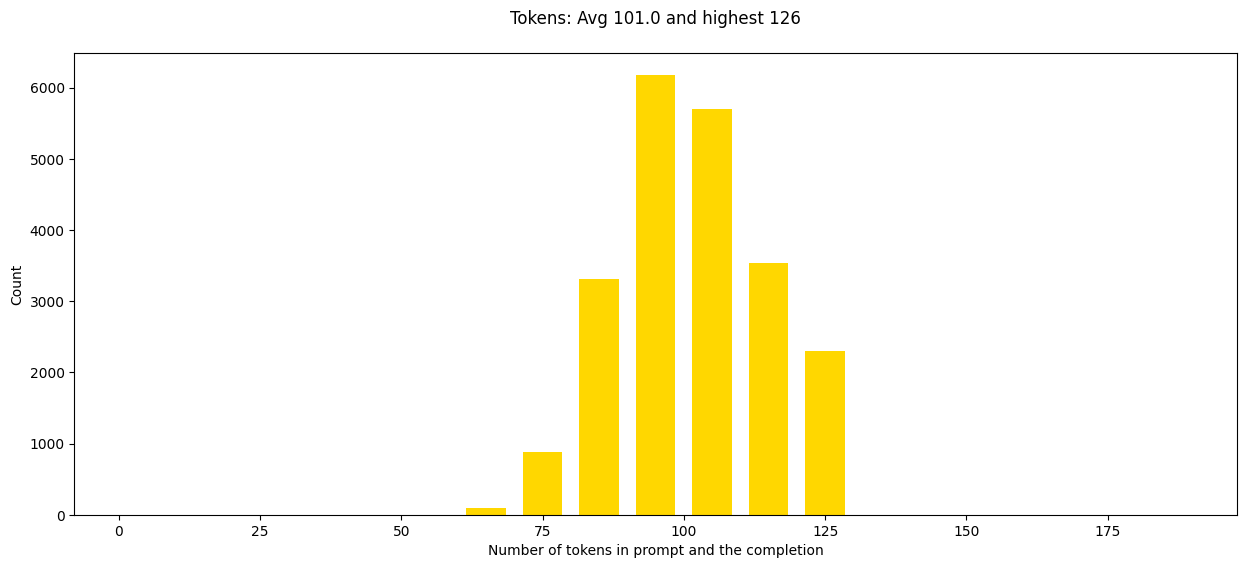

In [15]:
plt.figure(figsize=(15, 6))
plt.title(f"Tokens: Avg {sum(prompt_token_counts)/len(prompt_token_counts):,.1f} and highest {max(prompt_token_counts):,}\n")
plt.xlabel('Number of tokens in prompt and the completion')
plt.ylabel('Count')
plt.hist(prompt_token_counts, rwidth=0.7, color="gold", bins=range(0, 200, 10))
plt.show()

In [ ]:
username = "ed-donner"
dataset = f"{username}/items_prompts_lite" if LITE_MODE else f"{username}/items_prompts_full"

Item.push_prompts_to_hub(dataset, train, val, test)

Here are the datasets in HuggingFace:

https://huggingface.co/datasets/ed-donner/items_prompts_lite

https://huggingface.co/datasets/ed-donner/items_prompts_full

Please see this notebook in Google Colab:

https://colab.research.google.com/drive/1pRIACXkbW7TiwBITwjD-RNstwhnV81AI?usp=sharing